# CycleGANs PyTorch

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import torch
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread, imsave
from src.utils import get_files
from src.style_transfer import draw_content

Using TensorFlow backend.


In [2]:
base_dir = '/Users/jcboyd/Data/IncuCyte/ZG-MS-CD8T_cytotoxicity/'
# base_dir = '/mnt/data40T/migrated_from_data2/jboyd/data/IncuCyte/ZG-MS-CD8T_cytotoxicity_unshifted'
experiment = 'raji_target'

train_files, val_files, test_files = get_files(base_dir, experiment)
all_files = train_files + val_files

to_export = []

for i in range(0, len(all_files), 110):  # jump over fields
    for j in range(0, 48, 12):  # jump one day at a time
        to_export.append(all_files[i + j])

pc_img = []

for file_name in to_export:
    pc_img.append(imread(os.path.join(base_dir, 'phase_contrast', file_name)))

No. train images: 1540
No. val images: 110
No. test images: 110


/Users/jcboyd/anaconda3/lib/python3.7/site-packages/skimage/external/tifffile/tifffile.py:2616: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


In [3]:
def preprocess_pc(img):

    return img / 255.

pc_img = [preprocess_pc(img) for img in pc_img]

In [4]:
crop_size = 128

crops = []

for pc in pc_img:
    for y in range(0, pc.shape[0] - crop_size, crop_size):
        for x in range(0, pc.shape[1] - crop_size, crop_size):
            pc_crop = pc[y:y+crop_size, x:x+crop_size]
            crops.append(pc_crop)

crops = np.stack(crops)
x_train, x_test = crops[:1120], crops[1120:]

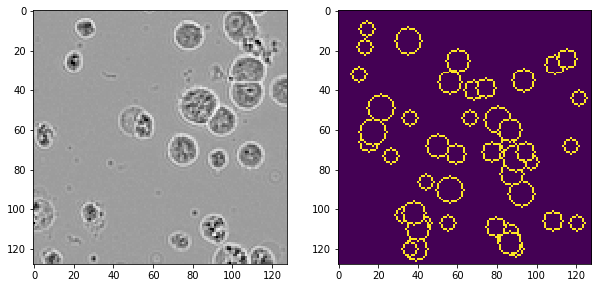

In [5]:
from src.style_transfer import draw_content

crop = 128

idx = np.random.randint(x_train.shape[0])
style_img = x_train[idx]

nb_cells = np.random.randint(10, 60)

content_img, masks, bboxes = draw_content(np.mean(x_train, axis=0), nb_cells=nb_cells)

fig, axes = plt.subplots(figsize=(10, 6), ncols=2)

axes[0].imshow(style_img, cmap='Greys_r')
axes[1].imshow(content_img)

In [6]:
from torch.nn import Module, Sequential
from torch.nn import Conv2d, ReLU, LeakyReLU, InstanceNorm2d, Tanh
from torch.nn import UpsamplingNearest2d, ZeroPad2d


class Downward(Module):

    def __init__(self, in_ch, out_ch, normalise=True):

        super(Downward, self).__init__()

        self.pool = Sequential(
            ZeroPad2d((1, 2, 1, 2)),
            Conv2d(in_ch, out_ch, kernel_size=4, stride=2),
            LeakyReLU(negative_slope=0.2, inplace=True))

        if normalise:
            self.pool.add_module('instance_norm', InstanceNorm2d(out_ch))

    def forward(self, x):
        x = self.pool(x)
        return x


class Upward(Module):

    def __init__(self, in_ch, out_ch):

        super(Upward, self).__init__()

        self.depool = Sequential(
            UpsamplingNearest2d(scale_factor=2),
            ZeroPad2d((1, 2, 1, 2)),
            Conv2d(in_ch, out_ch, kernel_size=4, stride=1),
            ReLU(inplace=True),
            InstanceNorm2d(out_ch))

    def forward(self, x1, x2):
        x = self.depool(x1)
        x = torch.cat((x, x2), dim=1)
        return x


class FNet(Module):

    def __init__(self, base_filters=32):

        super(FNet, self).__init__()

        self.down1 = Downward(1, base_filters)
        self.down2 = Downward(base_filters, 2 * base_filters)
        self.down3 = Downward(2 * base_filters, 4 * base_filters)
        self.down4 = Downward(4 * base_filters, 8 * base_filters)

        self.up1 = Upward(8 * base_filters, 4 * base_filters)
        self.up2 = Upward(8 * base_filters, 2 * base_filters)
        self.up3 = Upward(4 * base_filters, base_filters)

        self.out_conv = Sequential(
            UpsamplingNearest2d(scale_factor=2),
            ZeroPad2d((1, 2, 1, 2)),
            Conv2d(2 * base_filters, 1, kernel_size=4, stride=1),
            Tanh())

    def forward(self, x):

        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)

        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        
        x = self.out_conv(x)

        return x


class PatchGAN(Module):

    def __init__(self, base_filters=64):

        super(PatchGAN, self).__init__()

        self.down1 = Downward(1, base_filters, normalise=False)
        self.down2 = Downward(base_filters, 2 * base_filters)
        self.down3 = Downward(2 * base_filters, 4 * base_filters)
        self.down4 = Downward(4 * base_filters, 8 * base_filters)

        self.padding = ZeroPad2d((1, 2, 1, 2))
        self.validity = Conv2d(8 * base_filters, 1, kernel_size=4, stride=1)

    def forward(self, x):

        x = self.down1(x)
        x = self.down2(x)
        x = self.down3(x)
        x = self.down4(x)

        x = self.padding(x)
        x = self.validity(x)

        return x

In [7]:
def set_trainable(model, trainable):

    for param in model.parameters():

        param.requires_grad = trainable

        if not trainable:
            param.grad = None


def gen_cyclegan(crops, batch_size=1):

    base_img = np.zeros(crops.shape[1:])

    while True:

        # random sample
        idx = np.random.randint(crops.shape[0], size=batch_size)

        x_batch = crops[idx]

        # stochastic data augmentation
        if np.random.rand() > 0.5:
            x_batch = np.fliplr(x_batch)

        if np.random.rand() > 0.5:
            x_batch = np.flipud(x_batch)

        nb_cells = np.random.randint(10, 60)

        y_batch = np.array([draw_content(base_img, nb_cells=nb_cells, contour_intensity=1)[0]
                            for _ in range(batch_size)])

        # normalise to [-1, 1]
        x_batch = torch.tensor(2 * x_batch - 1).float()
        y_batch = torch.tensor(2 * y_batch - 1).float()

        yield x_batch[:, None, ...], y_batch[:, None, ...]


def sample_images(g_AB, g_BA, x_test, epoch):

    gen_test = gen_cyclegan(x_test, batch_size=1)
    data = next(gen_test)

    imgs_A = data[0].to(device)
    imgs_B = data[1].to(device)

    # Translate images to the other domain
    fake_B = g_AB(imgs_A)
    fake_A = g_BA(imgs_B)

    # Translate back to original domain
    reconstr_A = g_BA(fake_B)
    reconstr_B = g_AB(fake_A)

    gen_imgs = np.concatenate(list(map(lambda x : x.detach().cpu().numpy(),
                                       [imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])))

    # Rescale images
    gen_imgs = 0.5 * gen_imgs + 0.5

    titles = ['Original', 'Translated', 'Reconstructed']
    fig, axs = plt.subplots(2, 3)

    cnt = 0

    for i in range(2):

        for j in range(3):

            axs[i,j].imshow(gen_imgs[cnt].squeeze())
            axs[i, j].set_title(titles[j])
            axs[i,j].axis('off')
            cnt += 1

    fig.savefig('outputs/cyclegan_%04d.png' % epoch)
    plt.close()

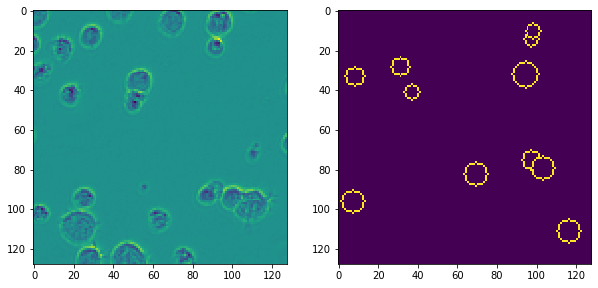

In [8]:
fig, axes = plt.subplots(figsize=(10, 5), ncols=2)

train_gen = gen_cyclegan(x_train)
imgs_A, imgs_B = next(train_gen)

axes[0].imshow(imgs_A.squeeze())
axes[1].imshow(imgs_B.squeeze())

assert -1 <= torch.min(imgs_A).item() and torch.max(imgs_A).item() <= 1
assert -1 <= torch.min(imgs_B).item() and torch.max(imgs_B).item() <= 1

#### Count params

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [10]:
d_A = PatchGAN().to(device)
d_B = PatchGAN().to(device)

g_AB = FNet().to(device)
g_BA = FNet().to(device)

total_params = 0

for params in g_AB.parameters():
    total_params += torch.prod(torch.tensor(params.size())).item()

print(total_params)

1542337


Note instance normalisation layers have two parameters in keras and so the number of parameters is $2 \times 3$ fewer for the discriminators and $2 \times 7$ fewer for the generators.

## Train model

In [42]:
from torch.nn import MSELoss, L1Loss
from torch.optim import Adam

h, w, c = x_train.shape[1], x_train.shape[2], 1
img_shape = (h, w, c)

disc_patch = (c, h // 2 ** 4, w // 2 ** 4)

# Loss weights
lambda_cycle = 10.0               # Cycle-consistency loss
lambda_id = 0.1 * lambda_cycle    # Identity loss

d_A = PatchGAN().to(device)
d_B = PatchGAN().to(device)

g_AB = FNet().to(device)
g_BA = FNet().to(device)

optimiser_dA = Adam(d_A.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimiser_dB = Adam(d_B.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimiser_combined = Adam(list(g_AB.parameters()) + list(g_BA.parameters()),
                          lr=2e-4, betas=(0.5, 0.999))

epochs = 200
batch_size = 1

# Adversarial loss ground truths
valid = torch.ones((batch_size,) + disc_patch)
fake = torch.zeros((batch_size,) + disc_patch)

train_gen = gen_cyclegan(x_train)
steps_per_epoch = x_train.shape[0] // batch_size // 4


def train_on_batch_discriminator(discriminator, imgs, optimiser):

    # clear previous gradients
    optimiser.zero_grad()

    real_imgs, fake_imgs = imgs
    inputs = torch.cat([real_imgs, fake_imgs]).to(device)

    valid = torch.ones((batch_size,) + disc_patch)
    fake = torch.zeros((batch_size,) + disc_patch)
    targets = torch.cat([valid, fake]).to(device)

    outputs = discriminator(inputs)

    # forward pass
    d_loss = MSELoss()(outputs, targets)

    # calculate gradients
    d_loss.backward()

    # descent step
    optimiser.step()

    return d_loss


def train_on_batch_combined(models, data, optimiser):
    
    # clear previous gradients
    optimiser.zero_grad()

    g_AB, g_BA, d_A, d_B = models
    imgs_A = data[0].to(device)
    imgs_B = data[1].to(device)

    valid = torch.ones((batch_size,) + disc_patch).to(device)

    # Translate images to the other domain
    fake_B = g_AB(imgs_A)
    fake_A = g_BA(imgs_B)

    # Translate images back to original domain
    reconstr_A = g_BA(fake_B)
    reconstr_B = g_AB(fake_A)

    # Identity mapping of images
    img_A_id = g_BA(imgs_A)
    img_B_id = g_AB(imgs_B)

    # Discriminators determines validity of translated images
    valid_A = d_A(fake_A)
    valid_B = d_B(fake_B)

    g_loss = MSELoss()(valid_A, valid) + MSELoss()(valid_B, valid) + \
             lambda_cycle * (L1Loss()(reconstr_A, imgs_A) + L1Loss()(reconstr_B, imgs_B)) + \
             lambda_id * (L1Loss()(img_A_id, imgs_A) + L1Loss()(img_B_id, imgs_B))

    # calculate gradients
    g_loss.backward()

    # descent step
    optimiser.step()

    return g_loss
    

for epoch in range(epochs):

    for batch_i in range(steps_per_epoch):

        data = next(train_gen)
        imgs_A = data[0].to(device)
        imgs_B = data[1].to(device)

        # Translate images to opposite domain
        fake_B = g_AB(imgs_A)
        fake_A = g_BA(imgs_B)

        # Train discriminators (original images = real / translated = Fake)
        set_trainable(d_A, True)
        set_trainable(d_B, True)

        dA_loss = train_on_batch_discriminator(d_A, [imgs_A, fake_A], optimiser_dA)
        dB_loss = train_on_batch_discriminator(d_B, [imgs_B, fake_B], optimiser_dB)

        d_loss = 0.5 * torch.add(dA_loss, dB_loss).item()

        # Train combined CycleGAN
        g_loss = train_on_batch_combined([g_AB, g_BA, d_A, d_B], [imgs_A, imgs_B], optimiser_combined).item()

        # Plot the progress
        print('[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %05f]' % (
            epoch, epochs, batch_i, steps_per_epoch, d_loss, g_loss))

    # visualise progress
    sample_images(g_AB, g_BA, x_test, epoch)

    # save model weights
    torch.save(g_AB.state_dict(), './weights/g_ab_%d.h5' % epoch)
    torch.save(g_BA.state_dict(), './weights/g_ba_%d.h5' % epoch)
    torch.save(d_A.state_dict(), './weights/d_a_%d.h5' % epoch)
    torch.save(d_B.state_dict(), './weights/d_b_%d.h5' % epoch)

[Epoch 0/200] [Batch 0/1] [D loss: 0.823033] [G loss: 18.512867]
[Epoch 1/200] [Batch 0/1] [D loss: 0.757283] [G loss: 19.781342]
[Epoch 2/200] [Batch 0/1] [D loss: 0.739378] [G loss: 18.693369]


KeyboardInterrupt: 

In [20]:
epoch = 146

# rcnn.load_state_dict(torch.load(save_path, map_location=torch.device('cpu')))
# rcnn = rcnn.eval()

generator = FNet()
save_path = '/Users/jcboyd/Desktop/g_ba_%d.h5' % epoch
generator.load_state_dict(torch.load(save_path, map_location=torch.device('cpu')))
generator = generator.eval()

In [21]:
data = next(train_gen)
imgs_A = data[0].to(device)
imgs_B = data[1].to(device)

In [32]:
img = generator(imgs_B).detach().cpu().numpy()

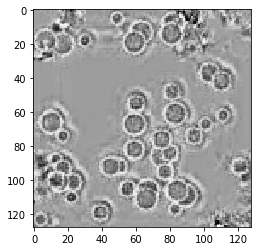

In [36]:
plt.imshow(img.squeeze(), cmap='Greys_r')

In [152]:
import torch
import torch.nn as nn
import torch.optim as optim

n_dim = 5

p1 = nn.Linear(n_dim, 1)
p2 = nn.Linear(n_dim, 1)

optimizer = optim.Adam(list(p1.parameters())+list(p2.parameters()))
p1.weight.requires_grad = True
p2.weight.requires_grad = False
for i in range(10):
    dummy_loss = (p1(torch.rand(n_dim)) + p2(torch.rand(n_dim))).squeeze()
    optimizer.zero_grad()
    dummy_loss.backward()
    optimizer.step()
    print('p1: requires_grad =', p1.weight.requires_grad, ', gradient:', p1.weight.grad, ', p1: ', p1.weight)
#     print('p2: requires_grad =', p2.weight.requires_grad, ', gradient:', p2.weight.grad, ', p2: ', p2.weight)
    print()

    if i == 1:
        p1.weight.requires_grad = False
        p1.weight.grad = None
        p2.weight.requires_grad = True
        
    if i == 5:
        p1.weight.requires_grad = True


p1: requires_grad = True , gradient: tensor([[0.6046, 0.8140, 0.9521, 0.6175, 0.3990]]) , p1:  Parameter containing:
tensor([[-0.0019,  0.3950, -0.1681, -0.4242, -0.1379]], requires_grad=True)

p1: requires_grad = True , gradient: tensor([[0.1942, 0.6954, 0.0014, 0.4799, 0.8842]]) , p1:  Parameter containing:
tensor([[-0.0027,  0.3940, -0.1688, -0.4252, -0.1388]], requires_grad=True)

p1: requires_grad = False , gradient: None , p1:  Parameter containing:
tensor([[-0.0027,  0.3940, -0.1688, -0.4252, -0.1388]])

p1: requires_grad = False , gradient: None , p1:  Parameter containing:
tensor([[-0.0027,  0.3940, -0.1688, -0.4252, -0.1388]])

p1: requires_grad = False , gradient: None , p1:  Parameter containing:
tensor([[-0.0027,  0.3940, -0.1688, -0.4252, -0.1388]])

p1: requires_grad = False , gradient: None , p1:  Parameter containing:
tensor([[-0.0027,  0.3940, -0.1688, -0.4252, -0.1388]])

p1: requires_grad = True , gradient: tensor([[0.8064, 0.1330, 0.0389, 0.6370, 0.5690]]) , p1:  P